In [1]:
import pathlib
import scipy.constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fytok.Tokamak import Tokamak
from fytok.modules.CoreProfiles import CoreProfiles
from fytok.modules.Equilibrium import Equilibrium
from spdm.view import View as sp_view
from spdm.data.Path import Path
from spdm.data.Function import Function

data_path = pathlib.Path("/home/salmon/workspace/fytok_data/data/15MA inductive - burn")

astra_profiles = pd.read_excel(
    next(data_path.glob("*ASTRA.xls")).absolute().as_posix(), sheet_name=1, header=10, usecols="B:BN"
)

2024-01-09 15:02:02,250 [    spdm]     INFO: 
###################################################################################################

    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = alpha  (spdm=beta extension=0.2.2.dev19+g14adade.d20231205, imas_version=v3_38_1_dirty)

 Run by salmon at 2024-01-09T15:02:02.127420.
 Job ID: fytok_salmon_surface_18412

###################################################################################################



In [2]:
core_profiles_astra = CoreProfiles(
    f"file+iterprofiles://{next(data_path.glob('*ASTRA.xls')).absolute().as_posix()}#core_profiles"
)

core_profiles_1d_astra = core_profiles_astra.time_slice.current.profiles_1d

equilibrium_astra = Equilibrium(f"file+geqdsk://{next(data_path.glob('**/g*.txt')).absolute().as_posix()}#equilibrium")


2024-01-09 15:02:02,521 [    spdm]     INFO: Load module spdm.plugins.data.plugin_iterprofiles
2024-01-09 15:02:02,586 [    spdm]     INFO: Initialize module fytok.modules.CoreProfiles 
2024-01-09 15:02:02,635 [    spdm]     INFO: Load module fytok.plugins.equilibrium.fy_eq
2024-01-09 15:02:02,637 [    spdm]     INFO: Load module spdm.plugins.data.plugin_geqdsk
2024-01-09 15:02:02,654 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.fy_eq-FyTok 


In [3]:
tokamak = Tokamak(
    f"file+iterprofiles://{next(data_path.glob('*ASTRA.xls')).absolute().as_posix()}",
    f"file+geqdsk://{next(data_path.glob('**/g*.txt')).absolute().as_posix()}",
    device="iter",
    shot=900003,
    equilibrium={"code": {"parameters": {"psi_norm": np.linspace(0.0001, 0.999, 128)}}},
    core_transport={
        "model": [
            {"code": {"name": "dummy"}},
            # {"code": {"name": "fast_alpha"}},
        ]
    },
    core_sources={
        "source": [
            {"code": {"name": "dummy"}},
            # {"code": {"name": "fusion", "parameters": {"fusion_reactions": ["D(t,n)alpha"]}}},
            # {"code": {"name": "radiation"}},
            # {"code": {"name": "synchrotron_radiation"}},
            # {"code": {"name": "collisional_equipartition"}},
        ]
    },
    transport_solver={
        "code": {
            "name": "fy_trans",
            "parameters": {
                "rho_tor_norm": np.linspace(0.01, 0.995, 128),
                # "bvp_rms_mask": [0.96],
                "hyper_diff": 1.0e-5,
                "max_nodes": 512,
                "bc_tol": 1,
                "verbose": 2,
                "units": {
                    "*/density": 1.0e21,
                    "*/density_flux": 1.0e24,
                    "ion/alpha/density": 1.0e18,
                    "ion/alpha/density_flux": 1.0e21,
                    "*/temperature": 1.0e6,
                    "*/temperature_flux": 1.0e27,
                },
            },
        },
        "ion_thermal": ["D", "T"],  #
        # "ion_non_thermal": ["alpha", "He"],
        # "impurities": ["Ar", "Be"],
        "boundary_condition_type": {
            # fmt: off
            # psi                          at axis \frac{d\psi}{dx}=0  , at boundary \psi=?
            "psi"                       : 1, 
            # density                      at axis \Gamma_s=0          , at boundary n=?
            "*/density"                 : 1, 
            # temperatur                   at axis \frac{dT}{dx}=0     , at boundary T=?
            "*/temperature"             : 1,
            # fmt: on
        },
    },
)
tokamak.initialize()

2024-01-09 15:02:02,685 [    spdm]     INFO: Load module spdm.plugins.data.plugin_xml
2024-01-09 15:02:02,771 [    spdm]     INFO: Initialize module fytok.modules.CoreProfiles 
2024-01-09 15:02:02,774 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.FyEqAnalyze 
2024-01-09 15:02:02,783 [    spdm]     INFO: Initialize module fytok.modules.Wall 
2024-01-09 15:02:02,785 [    spdm]     INFO: Initialize module fytok.modules.TF 
2024-01-09 15:02:02,788 [    spdm]     INFO: Initialize module fytok.modules.Magnetics 
2024-01-09 15:02:02,793 [    spdm]     INFO: Initialize module fytok.modules.PFActive 
2024-01-09 15:02:02,799 [    spdm]     INFO: Initialize module fytok.modules.CoreSources 
2024-01-09 15:02:02,806 [    spdm]     INFO: Initialize module fytok.plugins.core_sources.source.dummy 
2024-01-09 15:02:02,814 [    spdm]     INFO: Initialize module fytok.modules.CoreTransport 
2024-01-09 15:02:02,819 [    spdm]     INFO: Initialize module fytok.plugins.core_transport.mode

In [4]:
solver = tokamak.transport_solver

In [5]:
solver_1d = solver.preprocess(
    time=0.0,
    # fmt:off
    initial_value={
        "psi":0.0,
        "ion/D/density":                    1.0e19,
        "ion/T/density":                    1.0e19,
        "ion/He/density":                   1.0,
        "ion/alpha/density":                1.0,

        "ion/D/temperature":                2.0e3,
        "ion/T/temperature":                2.0e3,
        "ion/He/temperature":               2.0e3,
        "electrons/temperature":            2.0e3,
    },
    boundary_value={
        "ion/D/density":                    1.3e19, 
        "ion/T/density":                    1.3e19, 
        "ion/He/density":                   1.0, 
        "ion/alpha/density":                1.0, 

        "ion/D/temperature":                200,   
        "ion/T/temperature":                200,   
        "ion/He/temperature":               200,   
        "electrons/temperature":            200,   
    },
    # fmt:on
)

2024-01-09 15:02:02,899 [    spdm]     INFO: Load module spdm.mesh.mesh_rectangular
2024-01-09 15:02:02,933 [    spdm]  WARNING: /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/fy_eq/fy_eq.py:131:__init__: Singular values are caused when psi_norm takes values of 0.0 or 1.0.! 0.0 1.0


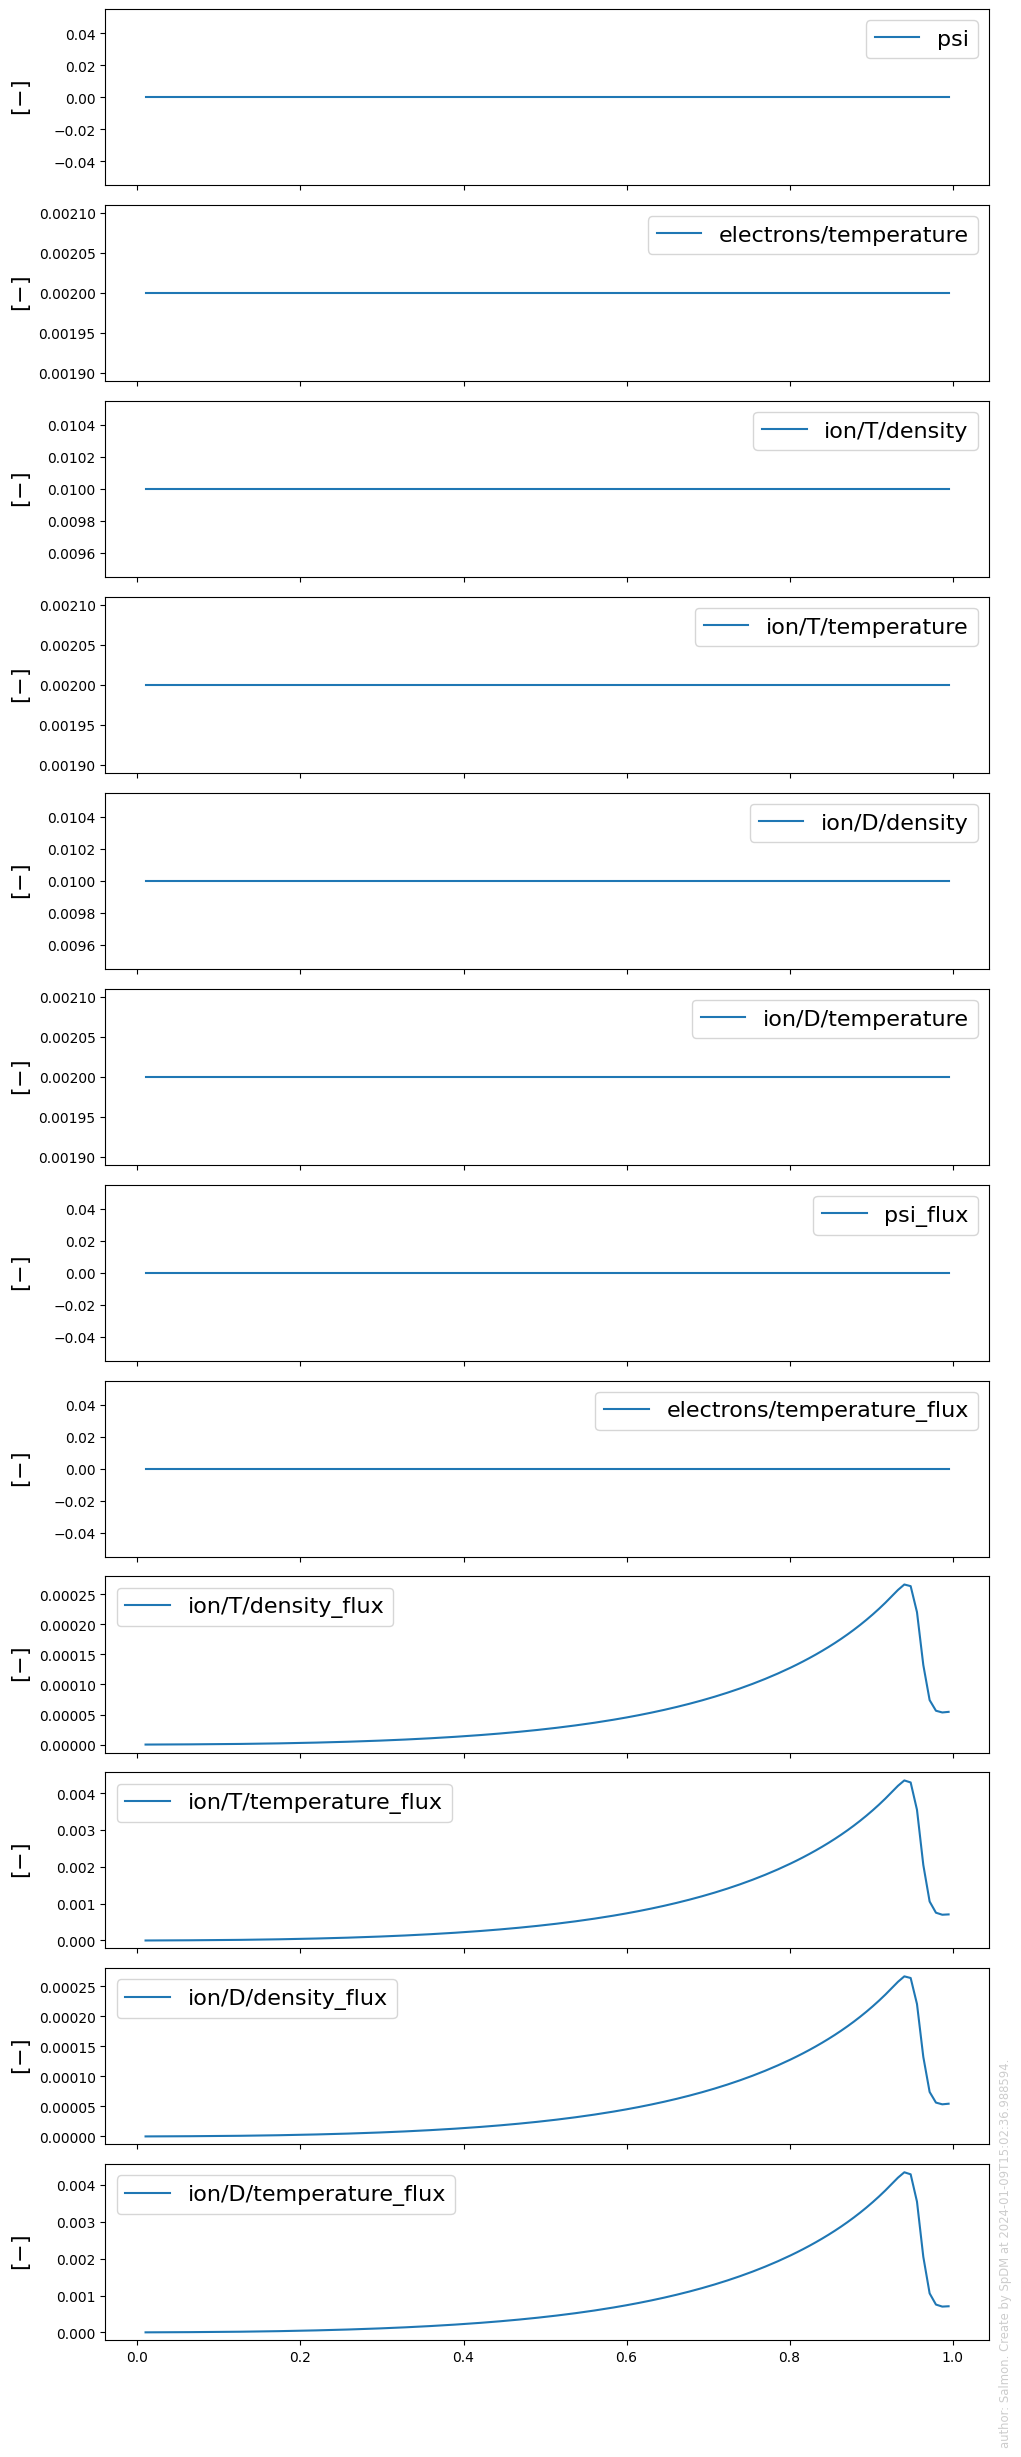

In [10]:
fig = sp_view.plot(
    solver_1d.X,
    *[(solver_1d.Y[idx * 2], equ.identifier) for idx, equ in enumerate(solver.equations)],
    *[(solver_1d.Y[idx * 2+1], f"{equ.identifier}_flux") for idx, equ in enumerate(solver.equations)],
)

In [7]:
len(solver_1d.equations[1])

0

In [8]:
solver.refresh(
    time=0.0,
    # fmt:off
    initial_value={
        "psi":0.0,
        "ion/D/density":                    1.0e19,
        "ion/T/density":                    1.0e19,
        "ion/He/density":                   1.0,
        "ion/alpha/density":                1.0,

        "ion/D/temperature":                2.0e3,
        "ion/T/temperature":                2.0e3,
        "ion/He/temperature":               2.0e3,
        "electrons/temperature":            2.0e3,
    },
    boundary_value={
        "ion/D/density":                    1.3e19, 
        "ion/T/density":                    1.3e19, 
        "ion/He/density":                   1.0, 
        "ion/alpha/density":                1.0, 

        "ion/D/temperature":                200,   
        "ion/T/temperature":                200,   
        "ion/He/temperature":               200,   
        "electrons/temperature":            200,   
    },
    # fmt:on
)
solver_1d = tokamak.transport_solver.time_slice.current

2024-01-09 15:02:04,443 [    spdm]     INFO: Solve transport equations : psi  ,electrons/temperature  ,ion/T/density  ,ion/T/temperature  ,ion/D/density  ,ion/D/temperature
2024-01-09 15:02:04,445 [    spdm]     INFO: Execute module fytok.plugins.transport_solver_numerics.fy_trans FyTrans


AttributeError: 'FyTrans' object has no attribute '_rho_tor_norm'

In [ ]:
fig = sp_view.plot(
    solver_1d.X,
    *[(solver_1d.Y[idx * 2], equ.identifier) for idx, equ in enumerate(solver_1d.equations)],
    *[(solver_1d.Y[idx * 2+1], f"{equ.identifier}_flux") for idx, equ in enumerate(solver_1d.equations)],
)

In [ ]:
tokamak.flush()
core_profiles_1d = tokamak.core_profiles.time_slice.current.profiles_1d

In [ ]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    [
        (core_profiles_1d.psi, r"$\psi$"),
        (
            equilibrium_astra.time_slice.current.profiles_1d.psi(solver_1d.grid.psi_norm),
            {"label": r"$\psi$ astra", "$matplotlib": {"linestyle": "dashed"}},
        ),
    ],
    *[
        [
            (Path(equ.identifier).get(core_profiles_1d, 0), f"{equ.identifier} "),
            (
                Path(equ.identifier).get(core_profiles_1d_astra, 0),
                {"label": f"{equ.identifier} astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
        ]
        for equ in solver_1d.equations
        if equ.identifier != "psi"
    ],
)

In [ ]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    [
        (core_profiles_1d.ion["alpha"].density, r"$\alpha$"),
        (core_profiles_1d.ion["He"].density, r"He"),
        (core_profiles_1d.ion["He"].density + core_profiles_1d.ion["alpha"].density, r"He+$\alpha$"),
        (core_profiles_1d_astra.ion["He"].density, {"label": f"He astra", "$matplotlib": {"linestyle": "dashed"}}),
    ],
    fontsize=10,
)

In [ ]:
source_1d = tokamak.core_sources.source[0].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    [(source_1d.electrons.particles, r"$S_{e}$")] + [(ion.particles, rf"$S_{{{ion.label}}}$") for ion in source_1d.ion],
    [(source_1d.electrons.energy, r"$Q_{e}$")],
    [(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in source_1d.ion],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

In [ ]:
source_1d = tokamak.core_sources.source[1].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    [
        (core_profiles_1d.electrons.temperature, r"$T_{e}$"),
        *[(ion.temperature, rf"$T_{{{ion.label}}}$") for ion in core_profiles_1d.ion],
    ],  # [(source_1d.electrons.particles, r"$S_{e}$")] + [(ion.particles, rf"$S_{{{ion.label}}}$") for ion in source_1d.ion],
    [
        (source_1d.electrons.energy, {"label": r"$Q_{e}$", "$matplotlib": {"linestyle": "-", "marker": "."}}),
        *[(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in source_1d.ion],
    ],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

In [ ]:
astra_rho_tor_norm = astra_profiles["x"].values
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    (
        Function(astra_rho_tor_norm, astra_profiles["Poh"].values * 1.0e6 / scipy.constants.electron_volt),
        r"$Q_{oh}$ astra",
    ),
    [
        (tokamak.core_sources.source[1].time_slice.current.profiles_1d.electrons.energy, r"$Q_{e}$"),
        *[
            (ion.energy, rf"$Q_{{{ion.label}}}$")
            for ion in tokamak.core_sources.source[1].time_slice.current.profiles_1d.ion
        ],
    ],
    [
        (
            Function(astra_rho_tor_norm, astra_profiles["Pdte"].values * 1.0e6 / scipy.constants.electron_volt),
            r"$Q_{dte}$ astra",
        ),
        (
            Function(astra_rho_tor_norm, astra_profiles["Pdti"].values * 1.0e6 / scipy.constants.electron_volt),
            r"$Q_{dti}$ astra",
        ),
        (
            Function(astra_rho_tor_norm, (astra_profiles["Pdt"].values) * 1.0e6 / scipy.constants.electron_volt),
            r"$Q_{dt}$ astra total",
        ),
    ],
    *[
        (
            Function(astra_rho_tor_norm, astra_profiles["Peic"].values * 1.0e6 / scipy.constants.electron_volt),
            r"$Q_{e}$ astra",
        ),
        (source_1d.electrons.energy, r"$Q_{e}$"),
    ],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=10,
)

In [ ]:
source_1d = tokamak.core_sources.source[2].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    [(source_1d.electrons.particles, r"$S_{e}$")] + [(ion.particles, rf"$S_{{{ion.label}}}$") for ion in source_1d.ion],
    [(source_1d.electrons.energy, r"$Q_{e}$")],
    [(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in source_1d.ion],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

In [ ]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    *sum(
        [
            [
                # (solver_1d.Y0[2 * idx], f"d({equ.identifier})/dr"),
                # (solver_1d.Y0[2 * idx + 1], f"d({equ.identifier}_flux)/dr"),
                (equ.d_dr, f"d({equ.identifier})/dr"),
                (equ.dflux_dr, f"d({equ.identifier}_flux)/dr"),
            ]
            for idx, equ in enumerate(solver_1d.equations)
        ],
        [],
    ),
)

In [ ]:
trans_1d = tokamak.core_transport.model[0].time_slice.current.profiles_1d
fig = sp_view.plot(
    trans_1d.grid_d.rho_tor_norm,
    (
        [
            (trans_1d.ion[0].particles.d, trans_1d.ion[0].label),
            (trans_1d.ion[1].particles.d, trans_1d.ion[1].label),
        ],
        {"y_label": "D"},
    ),
    (
        [
            (trans_1d.ion[0].particles.v, trans_1d.ion[0].label),
            (trans_1d.ion[1].particles.v, trans_1d.ion[1].label),
        ],
        {"y_label": "v"},
    ),
)

In [ ]:
source_1d = tokamak.core_sources.source[0].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    (
        [
            (source_1d.ion[0].particles, source_1d.ion[0].label),
            (source_1d.ion[2].particles, source_1d.ion[2].label),
        ],
        {"y_label": "Particles"},
    ),
    (
        [
            (source_1d.ion[0].energy, source_1d.ion[0].label),
            (source_1d.ion[2].energy, source_1d.ion[2].label),
        ],
        {"y_label": "Energy"},
    ),
)